# Utilities

In [ ]:
# for compatibility with the github

!pip install torch==1.4.0
!pip install torchvision==0.5.0

In [ ]:
import numpy as np
import pandas as pd
import torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, ToTensor , Normalize, Compose
import torch.optim as optim

from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
import os
import time

from sklearn.metrics import confusion_matrix
torch.manual_seed(seed=59) # set seed for reproducibility

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# def helper functions
@torch.no_grad()
def get_all_preds(data_loader, model, device):
    """Function to return all predicted probabilities"""
    all_preds = torch.tensor([]).to(device) # init empty tensor
    for batch in data_loader:
        imgs, lbls = batch
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds 
  
  

def get_correct(preds, lbls):
    """Function which tells us how many predictions are correct"""
    return preds.argmax(1).eq(lbls).sum().item()

# Preprocessing data

In [ ]:
batch_size = 100

transf = {
    "train":Compose([ToTensor(),Normalize(mean=[0.3814], std=[0.3994])]),
     "val": Compose([ToTensor(),Normalize(mean=[0.3814], std=[0.3994])])
             }

root_dir = "./data/fashion_mnist"

train_data = torchvision.datasets.FashionMNIST(root=root_dir, train=True,
                                               transform=transf['train'], 
                                               download=True )

val_data = torchvision.datasets.FashionMNIST(root=root_dir, train=False,
                                               transform=transf['val'], 
                                               download=True )

# train dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

# test dataloaders
train_test_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
val_test_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

# Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, input_channels=1, dims=28, num_classes=2):
        super(type(self), self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        dims = int((dims-4)/2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        dims = int((dims-4)/2)
        self.fc1 = nn.Linear(16*dims*dims, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc(out)
        return out

# Training (with training and validation scores)

In [ ]:
n_epochs = 50
validate_every = 2000
model = LeNet5(num_classes=10).to(device)
optimizer = optim.Adam(lr=0.001,weight_decay = 1e-6, params=model.parameters())
criterion = nn.CrossEntropyLoss(reduction="mean")

train_cross_entropy = []
train_accuracy = []
validation_cross_entropy = []
validation_accuracy = []

best_model_accuracy = 0

for epoch in range(n_epochs):
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(train_loader):
        x, labels = batch
        x, labels = x.to(device), labels.to(device)
        N = x.shape[0]
        
        # training mode (for things like dropout)
        model.train()
        
        # clear previous gradients
        optimizer.zero_grad()
        
        y_hat = model(x)
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()
        
        train_cross_entropy.append(loss)
        
        n_correct += (torch.argmax(y_hat, dim=1) == labels).sum().item()
        n_total += N
        
        # evaluation mode (e.g. adds dropped neurons back in)
        model.eval()
        if i % validate_every == 0:
            n_val_correct = 0
            n_val_total = 0
            v_cross_entropy_sum = 0
            
            # don't calculate gradients here
            with torch.no_grad():
                for j, v_batch in enumerate(val_loader):
                    v_x, v_labels = v_batch
                    v_x, v_labels = v_x.to(device), v_labels.to(device)
                    v_N = v_x.shape[0]
                    
                    v_y_hat = model(v_x)
                    v_loss = criterion(v_y_hat, v_labels)
                    v_cross_entropy_sum += v_loss
                    n_val_correct += (torch.argmax(v_y_hat, dim=1) == v_labels).sum().item()
                    n_val_total += v_N

            print(f"[epoch {epoch + 1}, iteration {i}] \t accuracy: {n_val_correct / n_val_total} \t cross entropy: {v_cross_entropy_sum / n_val_total}")
            validation_accuracy.append(n_val_correct / n_val_total)
            validation_cross_entropy.append(v_cross_entropy_sum / n_val_total)
            if n_val_correct / n_val_total >= best_model_accuracy:
                best_model_accuracy = n_val_correct / n_val_total
                print("saving")
                torch.save(model.state_dict(), './models/lenet5_fashion_mnist_3')
    
    print(f"epoch {epoch + 1} accumulated train accuracy: {n_correct / n_total}")
    train_accuracy.append(n_correct / n_total)

[epoch 1, iteration 0] 	 accuracy: 0.1507 	 cross entropy: 0.022962430492043495
saving
epoch 1 accumulated train accuracy: 0.7500333333333333
[epoch 2, iteration 0] 	 accuracy: 0.8218 	 cross entropy: 0.004837319254875183
saving
epoch 2 accumulated train accuracy: 0.8427166666666667
[epoch 3, iteration 0] 	 accuracy: 0.8576 	 cross entropy: 0.003966268617659807
saving
epoch 3 accumulated train accuracy: 0.8672833333333333
[epoch 4, iteration 0] 	 accuracy: 0.8626 	 cross entropy: 0.003704655449837446
saving
epoch 4 accumulated train accuracy: 0.8798333333333334
[epoch 5, iteration 0] 	 accuracy: 0.8784 	 cross entropy: 0.0033491889480501413
saving
epoch 5 accumulated train accuracy: 0.8879666666666667
[epoch 6, iteration 0] 	 accuracy: 0.8823 	 cross entropy: 0.0032450605649501085
saving
epoch 6 accumulated train accuracy: 0.8933833333333333
[epoch 7, iteration 0] 	 accuracy: 0.8818 	 cross entropy: 0.0032133643981069326
epoch 7 accumulated train accuracy: 0.89775
[epoch 8, iteration 0

# Checking the validity of the model on the test dataset (2 parts)

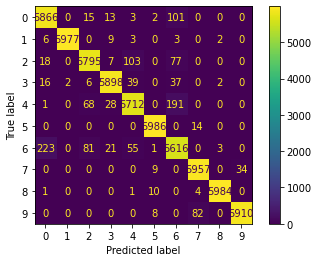

In [ ]:
tags = train_data.targets
probs = get_all_preds(data_loader=train_test_loader, model=model, device= device)
cm = confusion_matrix(y_true=tags, y_pred=probs.cpu().argmax(1))
ConfusionMatrixDisplay.from_predictions(y_true=tags, y_pred=probs.cpu().argmax(1))
plt.show()

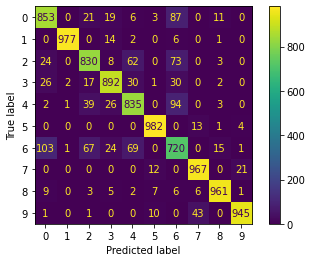

In [ ]:
val_tags = val_data.targets
probs_val = get_all_preds(data_loader=val_test_loader, model=model, device=device) # validation on held out test set
cm = confusion_matrix(y_true=val_tags, y_pred=probs_val.cpu().argmax(1))
ConfusionMatrixDisplay.from_predictions(y_true=val_tags, y_pred=probs_val.cpu().argmax(1))
plt.show()